## SQuAD 2.0

Reading comprehension/information retrieval models are the building blocks of chatbots that a lot of businesses are leveraging primarily for customer service. 

The Stanford Question Answering Dataset (SQuAD) is a reading comprehension dataset, consisting of questions on a set of Wikipedia articles, where the answer to answerable questions (there are questions that are impossible to answer with the information provided) is a segment or span within the corresponding reading passage. The objective is to build Neural Networks that will be able to predict the span of the answer within the corresponding passage or context. 



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
import gensim.models.word2vec as w2v
import sklearn.manifold
import glob
from tqdm import tqdm, tqdm_notebook
from functools import reduce

from keras.layers.embeddings import Embedding
from keras.layers import Dense, Dropout, RepeatVector, Flatten, recurrent, LSTM, Concatenate, Input
from keras.models import Sequential, Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.utils.np_utils import to_categorical
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

Using TensorFlow backend.


### Load in JSON File

In [2]:
train = pd.read_json('./data/train-v2.0.json')
test = pd.read_json('./data/dev-v2.0.json')

In [3]:
# train["data"][0]

In [4]:
# train_topics = []
# for aid in tqdm(range(len(train["data"]))):
#     topic = train["data"][aid]["title"]
#     train_topics.append(topic)
    
# print(len(train_topics))

In [5]:
# test_topics = []
# for aid in tqdm(range(len(test["data"]))):
#     topic = test["data"][aid]["title"]
#     test_topics.append(topic)
    
# print(len(test_topics))

In [6]:
#extract data from train JSON file to dictionary

train_dict = {"contexts": [], "questions": [], "answers": [], "answer_starts": []}

for aid in tqdm(range(len(train["data"]))):
    articles = train["data"][aid]["paragraphs"]
    for pid in range(len(articles)):
        qas = articles[pid]["qas"]
        for qid in range(len(qas)):
            if qas[qid]["is_impossible"] == False:
                context = articles[pid]["context"]
                train_dict["contexts"].append(context)
                question = qas[qid]["question"]
                train_dict["questions"].append(question)
                answer_text = qas[qid]["answers"]
                for a in answer_text:
                    answer_start = a["answer_start"]
                    train_dict["answer_starts"].append(answer_start)
                    answer = a["text"]
                    train_dict["answers"].append(answer)
#                     answer_end = answer_start + len(answer)
#                     train_dict["answer_ends"].append(answer_end)
                    

100%|██████████| 442/442 [00:00<00:00, 3652.74it/s]


In [7]:
#extract data from development/test JSON file to dictionary

test_dict = {"contexts": [], "questions": [], "answers": [], "answer_starts": []}

for aid in tqdm(range(len(test["data"]))):
    articles = test["data"][aid]["paragraphs"]
    for pid in range(len(articles)):
        qas = articles[pid]["qas"]
        for qid in range(len(qas)):
            if qas[qid]["is_impossible"] == False:
                context = articles[pid]["context"]
                test_dict["contexts"].append(context)
                question = qas[qid]["question"]
                test_dict["questions"].append(question)
                answer_text = qas[qid]["answers"][0]
                answer_start = answer_text["answer_start"]
                test_dict["answer_starts"].append(answer_start)
                answer = answer_text["text"]
                test_dict["answers"].append(answer)
#                 answer_end = answer_start + len(answer)
#                 test_dict["answer_ends"].append(answer_end)

100%|██████████| 35/35 [00:00<00:00, 3481.25it/s]


In [8]:
train_df = pd.DataFrame(train_dict)
test_df = pd.DataFrame(test_dict)

In [9]:
print(train_df.shape)
print(test_df.shape)

(86821, 4)
(5928, 4)


In [10]:
train_df.head()

,contexts,questions,answers,answer_starts
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,269
1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing,207
2,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003,526
3,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas",166
4,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s,276


In [11]:
test_df.head()

,contexts,questions,answers,answer_starts
0,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,France,159
1,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,10th and 11th centuries,94
2,The Normans (Norman: Nourmands; French: Norman...,From which countries did the Norse originate?,"Denmark, Iceland and Norway",256
3,The Normans (Norman: Nourmands; French: Norman...,Who was the Norse leader?,Rollo,308
4,The Normans (Norman: Nourmands; French: Norman...,What century did the Normans first gain their ...,10th century,671


##### SQuAD Dataset

Issues with Dataset:
  1. Some answers don't exactly match what's in the context.
  2. One word answers appear in multiple locations.

For the first iteration of this project, answers that did not exactly match what was in the context and were one word were removed.


### Preprocessing before modeling

In [12]:
#remove punctuation and set everything to lowercase on train dataframe

# for i in tqdm(train_df.select_dtypes(include=object).columns):
#     train_df[i] = train_df[i].str.replace("[^\w\s]",'')
#     train_df[i] = train_df[i].map(lambda x: x.lower())

In [13]:
#remove punctuation and set everything to lowercase on test dataframe

# for i in tqdm(test_df.select_dtypes(include=object).columns):
#     test_df[i] = test_df[i].str.replace("[^\w\s]",'')
#     test_df[i] = test_df[i].map(lambda x: x.lower())

In [14]:
#text_to_word_sequence on a copy of train dataframe to find the max len of each text column for padding

train_df_tk = train_df.copy()
for i in tqdm(train_df.select_dtypes(include=object).columns):
    train_df_tk[i] = train_df_tk[i].map(lambda x: text_to_word_sequence(x))

100%|██████████| 3/3 [00:06<00:00,  2.81s/it]


In [15]:
# text_to_word_sequence on a copy of test dataframe to find the max len of each text column for padding

test_df_tk = test_df.copy()
for i in tqdm(test_df.select_dtypes(include=object).columns):
    test_df_tk[i] = test_df_tk[i].map(lambda x: text_to_word_sequence(x))

100%|██████████| 3/3 [00:00<00:00,  4.81it/s]


In [16]:
# #creates a token index to token mapping

# def get_char_word_loc_mapping(context, context_tokens):
#     acc = '' # accumulator
#     current_token_idx = 0 # current word loc
#     mapping = dict()
#     word_starts = {"idx_start":[], "word_start":[]}
#     for char_idx, char in enumerate(context): # iterate through characters
#         if char != ' ': # if it's not a space:
#             acc += char # add to accumulator
#             context_token = context_tokens[current_token_idx] # current word token
#             if acc == context_token: # if the accumulator matches the current word token
#                 syn_start = char_idx - len(acc) + 1 # char loc of the start of this word
#                 word_starts["idx_start"].append(syn_start)
#                 word_starts["word_start"].append(current_token_idx)
# #                 for char_loc in range(syn_start, char_idx+1):
#                 mapping[current_token_idx] = acc # add to mapping
#                 acc = '' # reset accumulator
#                 current_token_idx += 1

#     return mapping

In [17]:
# word_idx = {"start_idx": [], "end_idx": []}
# for i in range(len(train_df_tk["contexts"])):
#     len_ans = len(train_df_tk["answers"][i])
#     mapping = get_char_word_loc_mapping(train_df["contexts"][i], train_df_tk["contexts"][i])
#     for k,v in mapping.items():
#         end_idx = k + (len_ans - 1)
#         if v == train_df_tk["answers"][i][0] and mapping[end_idx] == train_df_tk["answers"][i][-1]:
#             word_idx["start_idx"].append(k)
#             word_idx["end_idx"].append(end_idx)
#         else:
#             pass

In [18]:
#function returns the start and end token indices of answers within the document
#takes in the document and answers as a list of tokens

def find_startend_index(list_of_words, answer):
        len_ans = len(answer)
        list_of_words.append("")
        start_idx = [idx for idx,w in enumerate(list_of_words[:(-1*len_ans)]) if w == answer[0] and list_of_words[idx + (len_ans -1)] == answer[-1]]
#         print(start_idx)
#         if len(start_idx) != 1:
#             print(start_idx)
#             print(answer)
#             print(list_of_words)
        if len(start_idx) > 0 and len(start_idx) < 2:
            end_idx = start_idx[0] + (len_ans -1)
            return start_idx[0], end_idx     
        else:
            return None, None

In [19]:
train_word_idx = {"start_idx": [], "end_idx": []}
for i in range(len(train_df_tk["contexts"])):
    start_idx, end_idx = find_startend_index(train_df_tk["contexts"][i], train_df_tk["answers"][i])
    if start_idx == None  and end_idx == None:
        train_word_idx["start_idx"].append(None)
        train_word_idx["end_idx"].append(None)
    else:
        train_word_idx["start_idx"].append(int(start_idx))
        train_word_idx["end_idx"].append(int(end_idx))

In [20]:
test_word_idx = {"start_idx": [], "end_idx": []}
for i in range(len(test_df_tk["contexts"])):
    start_idx, end_idx = find_startend_index(test_df_tk["contexts"][i], test_df_tk["answers"][i])
    if start_idx == None and end_idx == None:
        test_word_idx["start_idx"].append(None)
        test_word_idx["end_idx"].append(None)
    else:
        test_word_idx["start_idx"].append(int(start_idx))
        test_word_idx["end_idx"].append(int(end_idx))

In [21]:
train_idx_df = pd.DataFrame(train_word_idx)
test_idx_df = pd.DataFrame(test_word_idx)

In [22]:
#concat start/end index dataframe with original

train_df_tk = pd.concat([train_df_tk, train_idx_df], axis=1)
test_df_tk = pd.concat([test_df_tk, test_idx_df], axis=1)

In [23]:
#drop rows where answers don't match exactly what's in the context
train_df_tk.dropna(inplace = True)
test_df_tk.dropna(inplace = True)

In [24]:
train_df_tk.reset_index(inplace=True)
test_df_tk.reset_index(inplace=True)

In [25]:
train_df_tk[train_df_tk["start_idx"].isnull()]

,index,contexts,questions,answers,answer_starts,start_idx,end_idx


In [26]:
len(train_df_tk["start_idx"])

75578

In [27]:
# train_df

In [28]:
Xc_sr = train_df_tk["contexts"]
Xq_sr = train_df_tk["questions"]
y_sr = train_df["answers"]
ys_sr = train_df_tk["start_idx"]
ye_sr = train_df_tk["end_idx"]

Xc_test_sr = test_df_tk["contexts"]
Xq_test_sr = test_df_tk["questions"]
y_test_sr = test_df["answers"]
ys_test_sr = test_df_tk["start_idx"]
ye_test_sr = test_df_tk["end_idx"]

Xc_tk = train_df_tk["contexts"]
Xq_tk = train_df_tk["questions"]

In [29]:
# tk = Tokenizer(num_words=10000)
# tk.fit_on_texts(total)

In [30]:
# len(tk.word_index)

In [31]:
# len_word_idx = len(tk.word_index)
# vocab_size = len_word_idx + 1
# word_idx = tk.word_index

In [32]:
NB_WORDS = 95219  #Number of unique words in vocabulary dictionary
MAX_LEN_C =  len(max(Xc_tk, key=len)) #Maximum number of words in context
MAX_LEN_Q =  len(max(Xq_tk, key=len)) #Maximum number of words in question

In [33]:
MAX_LEN_C

676

In [34]:
#function to tokenize a corpus
#takes in the corpus, unique vocabulary size, max len for padding

def tokenize_text(text, num_words, max_len):
    tk = Tokenizer(num_words=num_words)
    tk.fit_on_texts(text)
    text_seq = tk.texts_to_sequences(text)
    text_seq_pad = pad_sequences(text_seq, maxlen=max_len)
    return text_seq_pad

In [35]:
Xc_train = tokenize_text(Xc_sr, NB_WORDS, MAX_LEN_C)
Xq_train = tokenize_text(Xq_sr, NB_WORDS, MAX_LEN_Q)

Xc_test = tokenize_text(Xc_test_sr, NB_WORDS, MAX_LEN_C)
Xq_test = tokenize_text(Xq_test_sr, NB_WORDS, MAX_LEN_Q)

In [36]:
# y_train = tokenize_text(y_sr, NB_WORDS, MAX_LEN_C)
# y_test= tokenize_text(y_test_sr, NB_WORDS, MAX_LEN_C)

In [37]:
# y_train = train_df[["start_idx", "end_idx"]]
# y_test = test_df[["start_idx", "end_idx"]]

In [38]:
con_len = []
for i in tqdm(range(len(train_df_tk["start_idx"]))):
    con_len.append(len(train_df_tk["contexts"][i]))

100%|██████████| 75578/75578 [00:00<00:00, 75635.18it/s]


In [39]:
train_df_tk["context_length"] = con_len

In [40]:
# train_df_tk.head()

In [41]:
(train_df_tk[train_df_tk["context_length"] < train_df_tk["start_idx"]])

,index,contexts,questions,answers,answer_starts,start_idx,end_idx,context_length


In [42]:
y_array_train = np.zeros((len(train_df_tk["start_idx"]), MAX_LEN_C))
for i in tqdm(range(len(y_array_train))):
    idx = int(MAX_LEN_C - len(train_df_tk["contexts"][i]) + train_df_tk["start_idx"][i] - 1)
    y_array_train[i][idx] = 1


100%|██████████| 75578/75578 [00:02<00:00, 30504.11it/s]


In [43]:
y_array_test = np.zeros((len(test_df_tk["start_idx"]), MAX_LEN_C))
for i in tqdm(range(len(y_array_test))):
    idx = int(MAX_LEN_C - len(test_df_tk["contexts"][i]) + test_df_tk["start_idx"][i] - 1)
    y_array_test[i][idx] = 1

100%|██████████| 5059/5059 [00:00<00:00, 30414.90it/s]


### GloVe Embedding

https://nlp.stanford.edu/projects/glove/

In [44]:
# Create a dictionary of words to word vectors.

GLOVE_DIM = 300

glove_file = 'glove.6B.' + str(GLOVE_DIM) + 'd.txt'
emb_dict = {}
glove = open('./data/' + glove_file)
for line in tqdm(glove):
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

400000it [00:25, 15611.03it/s]


In [45]:
# total_Xc = pd.concat([Xc_sr, Xc_test_sr], axis = 0)
# total_Xq = pd.concat([Xq_sr, Xq_test_sr], axis = 0)

In [46]:
# #tokenize the concat corpuses to get the unique vocab list from tk.word_index

# tk_Xc = Tokenizer(num_words=NB_WORDS)
# tk_Xc.fit_on_texts(total_Xc)
# tk_Xc_train_seq = tk_Xc.texts_to_sequences(total_Xc)


# tk_Xq = Tokenizer(num_words=NB_WORDS)
# tk_Xq.fit_on_texts(total_Xq)
# tk_Xq_train_seq = tk_Xq.texts_to_sequences(total_Xq)

In [47]:
#concat the contexts and questions vertically to get a full vocabulary list.

total = pd.concat([Xc_sr, Xq_sr, Xc_test_sr, Xq_test_sr], axis = 0)

In [48]:
#tokenize the concat corpuses to get the unique vocab list from tk.word_index
tk = Tokenizer(num_words=95219)
tk.fit_on_texts(total)
tk_train_seq = tk.texts_to_sequences(total)

In [49]:
len(tk.word_index)

94434

In [50]:
#create an embedding matrix based on the pretrained GloVe word vectors
#use embedding matrix as weights in the embedding layer of Neural Network

emb_matrix = np.zeros((95219, GLOVE_DIM))

for w, i in tk.word_index.items():
    # The word_index contains a token for all words of the training data so we need to limit that
    if i < NB_WORDS:
        vect = emb_dict.get(w)
        # Check if the word from the training data occurs in the GloVe word embeddings
        # Otherwise the vector is kept with only zeros
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

In [51]:
# emb_matrix[1]

In [52]:
# #function that replaces words in corpus with pretrained GloVe word vectors

# def text_to_glove(text):
#     glove = text.copy()
#     for j, line in tqdm(enumerate(text)):
#         for i in range(len(line)):
#             vect = emb_dict.get(line[i])
#             if type(vect) != None:
#                 glove[j][i] = vect
#             else:
#                 glove[j][i] = np.zeros((1, 300))  
#     return glove


### Baseline Model with GloVe Embedding

In [53]:
EMBED_HIDDEN_SIZE = 300
BATCH_SIZE = 32
EPOCHS = 50

In [81]:
#inputs
context_input = Input(shape=(MAX_LEN_C,), name="context_input")
question_input = Input(shape=(MAX_LEN_Q,), name="question_input")

#embedding layers with emb matrix weights based of pre-trained GloVe word vectors
context_embedding_layer = Embedding(NB_WORDS, 300, weights=[emb_matrix], input_length=MAX_LEN_C, trainable=False)
question_embedding_layer = Embedding(NB_WORDS,300, weights=[emb_matrix], input_length=MAX_LEN_Q, trainable=False)
context_embedded_sequences = context_embedding_layer(context_input)
question_embedded_sequences = question_embedding_layer(question_input)

#First read question, then read context conditioned on question output
#hidden state (h_state) and cell state (c_state) of question LSTM layer passed into context LSTM layer
question_encoder, h_state, c_state = LSTM(16, return_state=True, dropout=0.3)(question_embedded_sequences)
#co-attention 
context_encoder = LSTM(16, dropout=0.3)(context_embedded_sequences, initial_state=[h_state, c_state])


intermediate = Dense(MAX_LEN_C, activation='relu')(context_encoder)
predictions = Dense(MAX_LEN_C,activation='softmax', name='output')(intermediate)
model = Model(inputs=[context_input,question_input],outputs=predictions)
model.summary()

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
question_input (InputLayer)     (None, 40)           0                                            
__________________________________________________________________________________________________
context_input (InputLayer)      (None, 676)          0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 40, 300)      28565700    question_input[0][0]             
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 676, 300)     28565700    context_input[0][0]              
__________________________________________________________________________________________________
lstm_13 (L

In [82]:
plot_model(model, to_file='model.png')

In [83]:
history = model.fit({'context_input':Xc_train,'question_input':Xq_train},{'output':y_array_train},
          epochs=10, batch_size=BATCH_SIZE, validation_split = 0.3)

Train on 52904 samples, validate on 22674 samples
Epoch 1/10
52904/52904 [==============================] - 1058s 20ms/step - loss: 5.1879 - acc: 0.0100 - val_loss: 5.2034 - val_acc: 0.0082
Epoch 2/10
52904/52904 [==============================] - 1585s 30ms/step - loss: 5.1396 - acc: 0.0112 - val_loss: 5.1945 - val_acc: 0.0089
Epoch 3/10
52904/52904 [==============================] - 1664s 31ms/step - loss: 5.1226 - acc: 0.0122 - val_loss: 5.2139 - val_acc: 0.0078
Epoch 4/10
52904/52904 [==============================] - 1661s 31ms/step - loss: 5.1054 - acc: 0.0130 - val_loss: 5.2135 - val_acc: 0.0096
Epoch 5/10
52904/52904 [==============================] - 1667s 32ms/step - loss: 5.0875 - acc: 0.0144 - val_loss: 5.2125 - val_acc: 0.0090
Epoch 6/10
52904/52904 [==============================] - 1671s 32ms/step - loss: 5.0717 - acc: 0.0158 - val_loss: 5.2395 - val_acc: 0.0098
Epoch 7/10
52904/52904 [==============================] - 1668s 32ms/step - loss: 5.0566 - acc: 0.0162 - val_l

In [84]:
model.evaluate([Xc_test, Xq_test], y_array_test, batch_size=BATCH_SIZE)

5059/5059 [==============================] - 24s 5ms/step


[5.71524963663557, 0.0075113658825854916]

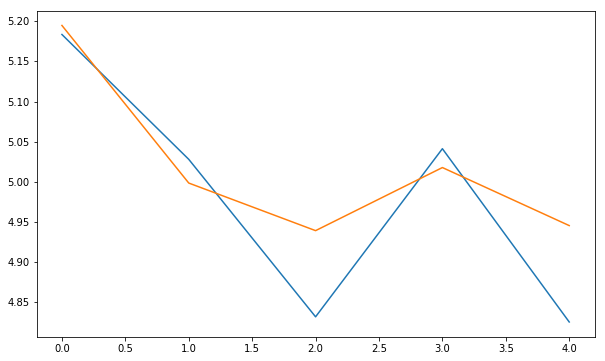

In [58]:
plt.figure(figsize=(10,6))
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Val_Loss")

In [85]:
predictions = model.predict([Xc_test, Xq_test])

In [86]:
len(predictions)

5059

In [87]:
predictions[0]

array([4.0877576e-14, 4.2965919e-14, 4.1320239e-14, 3.7270673e-14,
       4.0341889e-14, 3.2292199e-14, 3.7526257e-14, 4.2147502e-14,
       3.8352324e-14, 3.9366578e-14, 3.8221677e-14, 3.9173031e-14,
       4.3902104e-14, 4.1853182e-14, 3.9719022e-14, 3.9298531e-14,
       3.6890948e-14, 3.3713660e-14, 4.2239893e-14, 4.2612127e-14,
       4.3673510e-14, 3.6077224e-14, 3.6734440e-14, 3.6719871e-14,
       3.4045158e-14, 3.4461454e-14, 3.8636981e-14, 3.7250276e-14,
       3.4636675e-14, 3.9483431e-14, 4.1883370e-14, 4.0906511e-14,
       3.9833578e-14, 4.5505090e-14, 3.2102928e-14, 4.1025824e-14,
       4.2824051e-14, 3.9535354e-14, 4.1165347e-14, 4.4694791e-14,
       3.9772012e-14, 4.2568586e-14, 3.9656117e-14, 3.6900940e-14,
       3.9541616e-14, 4.3200527e-14, 3.8942540e-14, 3.8747607e-14,
       3.3832576e-14, 4.2092872e-14, 4.0909865e-14, 4.1492800e-14,
       4.0255800e-14, 3.9463932e-14, 4.0176640e-14, 4.6422779e-14,
       4.3673012e-14, 3.8626888e-14, 4.5379760e-14, 3.7325733e

In [62]:
# contrnn = Sequential()
# contrnn.add(Embedding(vocab_size, EMBED_HIDDEN_SIZE, input_length = MAX_LEN_C, weights=[emb_matrix], trainable=False))
# contrnn.add(Dropout(0.3))

# qrnn = Sequential()
# qrnn.add(Embedding(vocab_size, EMBED_HIDDEN_SIZE, input_length = MAX_LEN_Q))
# qrnn.add(Dropout(0.3))
# qrnn.add(LSTM(EMBED_HIDDEN_SIZE, return_sequences=False))
# qrnn.add(RepeatVector(MAX_LEN_C))

# model = Sequential()
# # model.add(Merge([sentrnn, qrnn], mode='sum'))
# model.add(Concatenate([contrnn, qrnn]))
# model.add(LSTM(EMBED_HIDDEN_SIZE, return_sequences=False))
# model.add(Dropout(0.3))
# model.add(Dense(2, activation='relu'))

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [63]:
%%script false
model.fit([Xc_train, Xq_train], y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.3)

In [64]:
%%script false
loss, acc = model.evaluate([tX, tXq], tY, batch_size=BATCH_SIZE)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))

### Word2Vec Embedding

In [ ]:
%%time 

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
VEC_DIM = 300    # Word vector dimensionality                      
MIN_COUNT = 40   # Minimum word count                        
WORKERS = 4     # Number of threads to run in parallel
WINDOW = 10    # Context window size                                                                                    
DOWN = 1e-3   # Downsample setting for frequent words

from gensim.models import word2vec
print("Training model...")

#Context
Xc = word2vec.Word2Vec(X, workers=WORKERS,
            size=VEC_DIM, min_count = MIN_COUNT,
            window = WINDOW, sample = DOWN)

#Questions
Xq = word2vec.Word2Vec(Xq, workers=WORKERS,
            size=VEC_DIM, min_count = MIN_COUNT,
            window = WINDOW, sample = DOWN)